In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplstereonet
import sys, os

#load utils for importing data
sys.path.append("G:\My Drive\Documents\PhD\Analysis\libs")
import pycompass
from pycompass.IOTools import ccXML
from pycompass.SNE import pdf

In [30]:
%matplotlib inline

In [31]:
#utitlity function for plotting grids
def plotGrids(titles, grid, values):
    """
    Plots a list of values on a gridded stereonets. The grid is 
    is expected to be a complete hemisphere in lat/long coordinates.
    """
        
    nAxes = len(values) #number of axes to draw
    bound = np.pi / 2 #boundaries of the stereonet hemisphere
    minV = 99999999999999999 #min for color ramp
    maxV = -9999999999999999 #max for color ramp
    
    patches = [] #list of patch objects for each grid
    for i in range(len(values)):
        
        #build patches for this grid
        patches.append([])
        
        #loop through points in grid and create patch objects
        for _lat,_lon in grid.T:
            patches[i].append(mpl.patches.Circle( (_lon, _lat), .02)) #store "dot" for plotting
        
        #check minV and maxV
        if np.min(values[i]) < minV:
            minV = np.min(values[i])
        if np.max(values[i]) > maxV:
            maxV = np.max(values[i])
    
    #init figure
    fig = plt.figure(figsize=(8 * nAxes, 8))
    
    #build throw-away axes to get color-ramp object
    cmap_name = "coolwarm" #plasma
    ax = fig.add_subplot(111, projection='stereonet')
    x = np.linspace(minV,maxV)
    y = np.linspace(minV,maxV)
    CS3 = ax.scatter(x,y,c=x, cmap=cmap_name)
    fig.clf()
    
    #create normalization object for color-mapping
    #now create colour map
    cmap = mpl.cm.get_cmap(cmap_name)
    norm = mpl.colors.Normalize(vmin=minV,vmax=maxV) 

    #build axes
    for i in range(nAxes):
        pos = "1%d%d" % (nAxes,i+1)
        ax = fig.add_subplot(pos, projection='stereonet')
        ax.set_title(titles[i],y=1.08)
        
        #reshape grid for matplotlib contourf
        res = int(np.sqrt(len(values[i])))
        assert res**2 == len(values[i]), "Error: values must be sampled from a square grid."
        vals = np.reshape(values[i],(res,res)).T
        
        #push contour points
        bound = np.pi / 2
        ax.contourf(np.linspace(-bound,bound,res),np.linspace(-bound,bound,res), vals,cmap="coolwarm")
        
        ax.grid() #grid
        
    #finally, add the color-ramp
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
    fig.colorbar(CS3, cax=cbar_ax)
    
    return fig
def vec2TrendPlunge(xyz):
    trend,plunge = np.rad2deg(np.arctan2(xyz[0],xyz[1])), np.rad2deg(-np.arcsin(xyz[2]))
    if (plunge < 0):
        trend,plunge = np.rad2deg(np.arctan2(-xyz[0],-xyz[1])), np.rad2deg(-np.arcsin(-xyz[2]))
    while (trend < 0):
        trend += 360
    return plunge,trend

In [32]:
#########################
#TEST PRIOR
#########################
#evaluate prior probability over grid
grid = pdf.grid(100)
normal = np.array([0.46976518, -0.75962028, 0.44977517])
normal = normal / np.linalg.norm(normal)
prior = pdf.prior(grid,normal)

[ 0.46976518 -0.75962028  0.44977517]


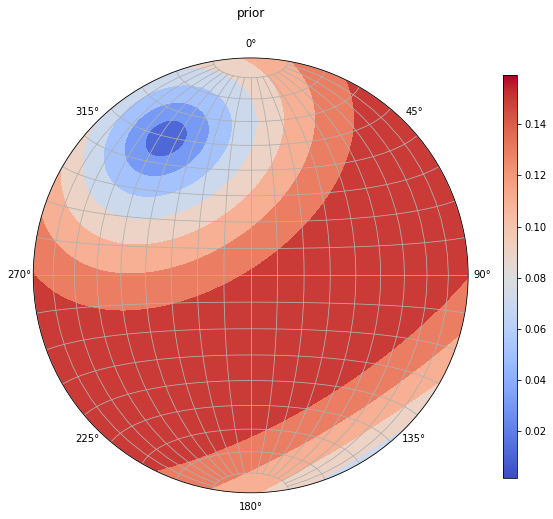

In [33]:
print (normal)
figure = plotGrids(["prior"],grid,[prior])

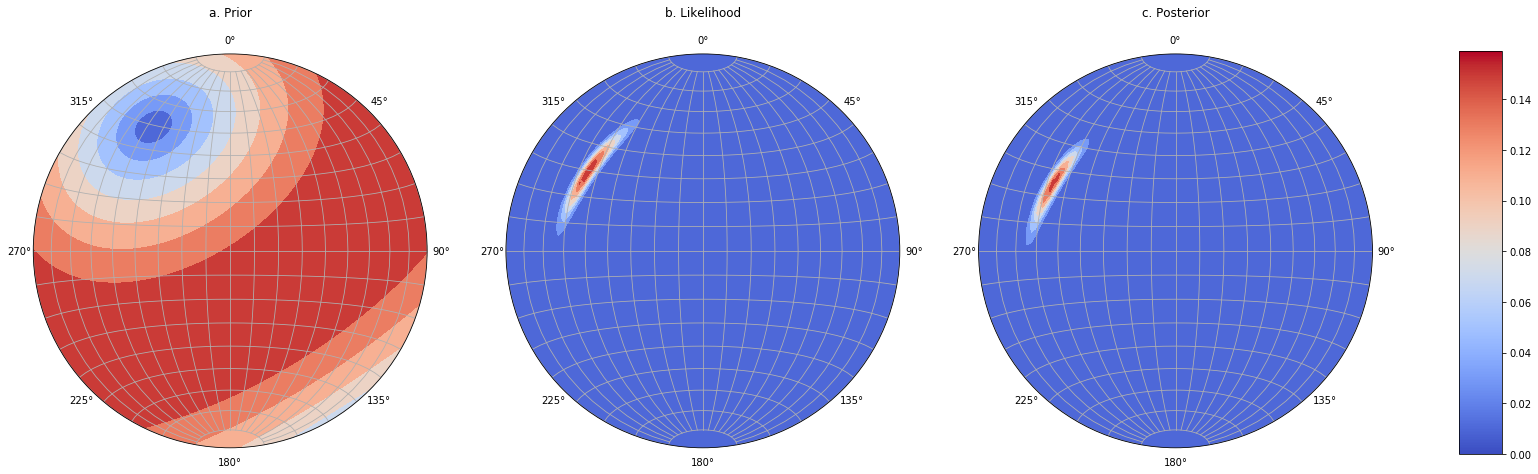

In [34]:
##########################################################
#TEST 1 - REPRODUCE KNOWN P MATRIX
#########################################################
phi = np.deg2rad(305)
theta = np.deg2rad(30)
alpha = np.deg2rad(0)
e1 = 2.0
e2 = 0.1
e3 = 0.025
n = 10
grid = pdf.grid(100)
cov =  pdf.constructCOV(phi,theta,alpha,e1,e2,e3)
#%timeit pdf.likelihood(grid,P*n,e2,e3,n)
likelihood = pdf.likelihoodExp1D(grid,cov,n)
posterior = likelihood * prior
#plot figure
figure = plotGrids(["a. Prior","b. Likelihood","c. Posterior"],grid,[prior,likelihood,posterior])

In [35]:
##########################################################
#TEST 1 - REPRODUCE KNOWN P MATRIX
#########################################################
phi = np.deg2rad(330)
theta = np.deg2rad(30)
alpha = np.deg2rad(0)
e1 = 5.0
e2 = 0.5
e3 = 0.4
n = 50
grid = pdf.grid(100)
cov =  pdf.constructCOV(phi,theta,alpha,e1,e2,e3)
lik = pdf.likelihoodExp1D(grid,cov,n)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


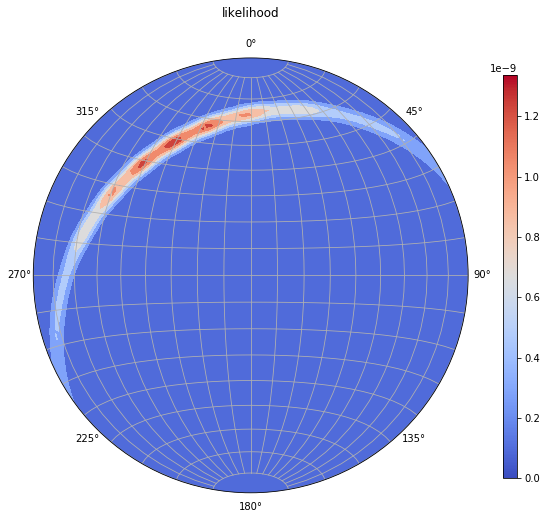

In [36]:
figure = plotGrids(["likelihood"],grid,[lik])
figure.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


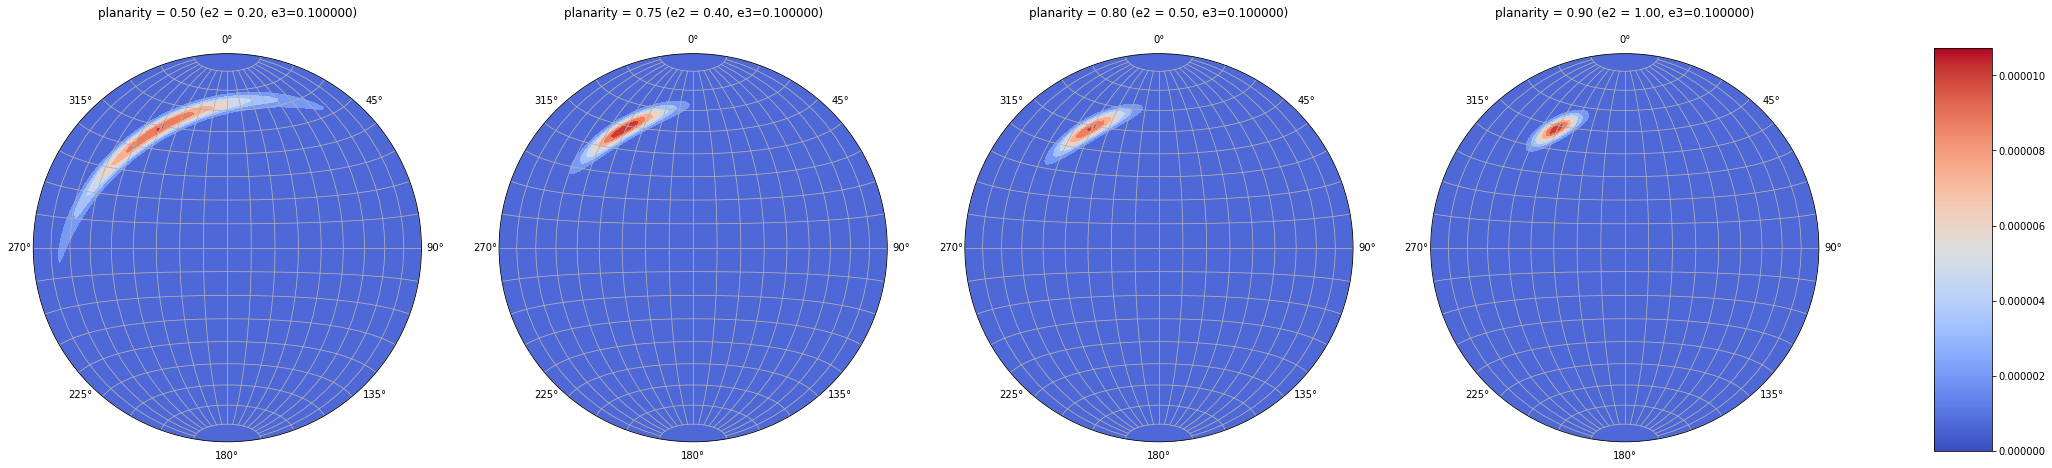

In [37]:
##########################################################
#TEST 2 - REPRODUCE KNOWN P MATRICES FROM PLANARITY VALUES
#########################################################
p = [0.5,0.75,0.8,0.9] #planarity value
e = [0.1]#,0.1,0.15] #eig3 value - these tend to be really small as the trace is long
n = 10
e1 = 5.0 #length of trace
grid = pdf.grid(100)
for _e in e:
    out = []
    titles=[]
    for _p in p:
        #calculate e2 from planarity
        e2 = _e/(1-_p)
        #build test P-matrix
        cov = pdf.constructCOV(phi, theta, alpha, e1, e2, _e)
        #create title
        titles.append("planarity = %.2f (e2 = %.2f, e3=%f)" % (_p,e2,_e))
        
        #sample
        out.append( pdf.likelihoodExp1D(grid,cov,n) ) #sample posterior (pretending we have 50 data points)

    stereonet = plotGrids(titles,grid,out) #plot results
    stereonet.show()

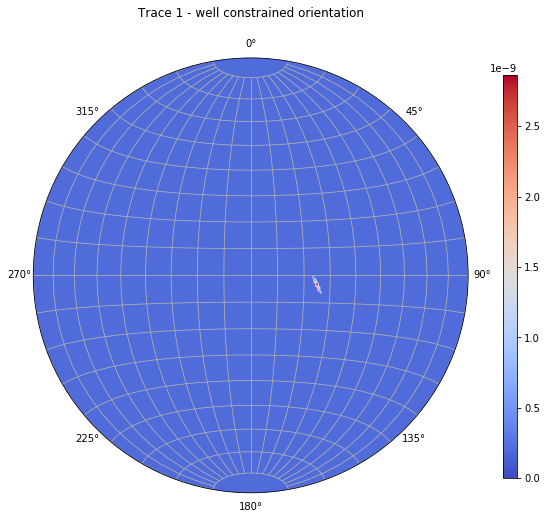

In [39]:
##############################################
##TEST ON SOME REAL TRACES
##############################################
##TRACE 1 - WELL DEFINED ORIENTATION
x = [660.255005,660.255005,660.262024,660.348999,660.431030,660.487976,660.554016,660.632019,660.700989,660.754028,660.844971,660.909973,661.008972,661.106995,661.197021,661.244995,661.348022,661.424988,661.523987,661.614014,661.700012,661.789978,661.893005,661.893005,661.893005,661.971008,662.070007,662.168030,662.270996,662.353027,662.439026,662.528992,662.614990,662.671997,662.762024,662.859985,662.924988,662.994995,663.093018,663.182983,663.268005,663.336975,663.427002,663.520996,663.585999,663.651001,663.708008,663.784973,663.854004,663.953003,664.046997,664.120972,664.219971,664.310974,664.409973,664.508972,664.590027,664.638977,664.729004,664.729004,664.729004,664.822998,664.875977,664.929016,665.026978,665.083984,665.179016,665.276978,665.370972,665.465027,665.567993,665.666016,665.765015,665.854980,665.932983,666.007019,666.088989,666.174988,666.260986,666.351013,666.421021,666.510986,666.580017,666.666016,666.752014,666.825012,666.903015,666.976990,667.054993,667.153015,667.239014,667.312012,667.369019,667.442017,667.536011,667.638977,667.711975,667.815002,667.896973,667.958008,668.052002,668.130005,668.130005,668.130005,668.169983,668.231018,668.309021,668.382019,668.465027,668.546997,668.632996,668.731995,668.830017,668.921021,669.020020,669.104980,669.195984,669.260986,669.351013,669.432007,669.526001,669.616028,669.705994,669.804016,669.906982,669.987976,670.070007,670.169006,670.263000,670.366028,670.455994,670.455994,670.455994,670.526001,670.620972,670.715027,670.783997,670.874023,670.973022,671.046021,671.145020,671.210022,671.270996,671.361023,671.429993,671.525024,671.611023,671.684021,671.757996,671.851990,671.950012,672.012024,672.101990,672.171021,672.270020,672.343018,672.445984,672.536011,672.630005,672.729004,672.810974,672.905029,672.994995,673.085022,673.174988,673.276978,673.380005,673.469971,673.469971,673.469971,673.513977,673.546021,673.565979,673.614014,673.695007,673.747009,673.794983,673.848022,673.921021,674.002014,674.067017,674.148010,674.234009,674.289978,674.346985,674.416016,674.473022,674.559021,674.632996,674.705994,674.705994,674.705994,674.776001,674.840027,674.918030,674.994995,675.075989,675.161987,675.205994,675.291016,675.364014,675.453979,675.536011,675.625000,675.728027,675.783997,675.848999,675.931030,675.982971,676.044006,676.117004,676.182007,676.189026,676.257996,676.302002,676.357971,676.398010,676.463013,676.549011,676.549011,676.549011,676.643005,676.708008,676.773010,676.870972,676.935974,677.030029,677.106995,677.151001,677.232971,677.309998,677.390991,677.460022,677.525024,677.581970,677.630005,677.716003,677.776001,677.848999,677.927002,677.982971,678.036011,678.104980,678.174011,678.237976,678.307007,678.380005,678.469971,678.526978,678.599976,678.698975,678.783997,678.812988,678.812988,678.812988,678.911011,678.997009,679.065979,679.130005,679.198975,679.239014,679.270996,679.322998,679.383972,679.448975,679.530029,679.604004,679.681030,679.745972,679.822998,679.895996,679.981995,680.062988,680.153015,680.221985,680.270020,680.302002,680.349976,680.403015,680.455017,680.499023,680.534973,680.598999,680.598999,680.598999,680.668030,680.716980,680.776978,680.830017,680.882019,680.942993,681.010986,681.096985,681.179016,681.268005,681.328979,681.414978,681.484009,681.570007,681.651978,681.754028,681.848022,681.913025,681.978027,682.039978,682.125000,682.210999,682.296021,682.390015,682.476013,682.557983,682.648010,682.737976,682.823975,682.823975,682.823975,682.918030,682.974976,683.060974,683.143005,683.208008,683.281006,683.359009,683.440002,683.521973,683.604004,683.669006,683.767029,683.810974,683.893005,683.979004,684.072998,684.145996,684.239990,684.314026,684.387024,684.435974,684.500977,684.573975,684.638977,684.638977,684.638977,684.708008,684.789001,684.879028,684.978027,685.039001,685.119995,685.193970,685.278992,685.335999,685.434021,685.479004,685.577026,685.645996,685.728027,685.825989,685.919983,686.018005,686.088013,686.182007,686.263000,686.348999,686.398010,686.398010,686.398010,686.447021,686.531982,686.617981,686.700012,686.784973,686.859009,686.943970,687.033997,687.116028,687.197021,687.262024,687.318970,687.372009,687.440979,687.440979,687.440979,687.518005,687.549988,687.598022,687.638000,687.697998,687.758972,687.799011,687.883972,687.948975,688.026001,688.036987,688.059998,688.112976,688.112976,688.112976,688.107971,688.143005,688.187012,688.236023,688.276001,688.312012,688.380005,688.469971,688.543030,688.637024,688.718994,688.804993,688.804993,688.804993,688.882019,688.947021,689.015991,689.064026,689.137024,689.213989,689.291992,689.340027,689.393005,689.453003,689.534973,689.534973,689.534973,689.575012,689.664978,689.721008,689.721008,689.721008,689.760986]    
y = [814.494019,814.494019,814.559021,814.531006,814.489014,814.476013,814.487976,814.474976,814.500000,814.494019,814.479004,814.489990,814.479004,814.507996,814.533020,814.578003,814.599976,814.648987,814.679016,814.684021,814.695984,814.679993,814.661011,814.661011,814.661011,814.669006,814.656982,814.666016,814.666016,814.666016,814.679016,814.682983,814.674988,814.703003,814.728027,814.737000,814.768982,814.793030,814.822998,814.869019,814.922974,814.968018,815.013977,815.052002,815.104980,815.158020,815.206970,815.257019,815.281006,815.289978,815.286011,815.281006,815.250000,815.234985,815.203003,815.192017,815.211975,815.255981,815.281006,815.281006,815.281006,815.297974,815.314026,815.330017,815.338013,815.366028,815.362976,815.392029,815.409973,815.427002,815.447998,815.456970,815.445984,815.450989,815.437988,815.432983,815.434021,815.445984,815.458984,815.463989,815.489014,815.513000,815.536987,815.549988,815.562012,815.578003,815.585999,815.601990,815.612000,815.620972,815.655029,815.690979,815.739990,815.776978,815.814026,815.835999,815.853027,815.854004,815.874023,815.893982,815.911011,815.940002,815.940002,815.940002,815.979004,815.999023,816.007019,816.002991,815.981995,815.981995,815.953003,815.942017,815.950012,815.955017,815.922974,815.956970,815.961975,815.994995,816.039978,816.080994,816.119995,816.166016,816.213013,816.242981,816.244995,816.307007,816.348999,816.359009,816.375977,816.377014,816.362000,816.362000,816.362000,816.385986,816.362976,816.380981,816.405029,816.408997,816.418030,816.434021,816.442993,816.476013,816.517029,816.541992,816.565979,816.562012,816.573975,816.591003,816.606995,816.622986,816.612000,816.630981,816.635986,816.659973,816.648987,816.664978,816.664978,816.669983,816.687012,816.695984,816.695984,816.713013,816.737976,816.783997,816.809998,816.830994,816.853027,816.836975,816.836975,816.836975,816.911011,816.987976,817.070007,817.135010,817.197021,817.275024,817.361023,817.439026,817.497009,817.559021,817.632996,817.695007,817.749023,817.818970,817.888977,817.934021,817.960999,817.932983,817.948975,817.966980,817.966980,817.966980,818.012024,818.085999,818.156982,818.228027,818.289978,818.344971,818.418030,818.471985,818.530029,818.575989,818.638977,818.684998,818.706970,818.776978,818.851013,818.914001,818.992004,819.052979,819.112000,819.187012,819.250977,819.317993,819.390991,819.460999,819.541992,819.594971,819.629028,819.629028,819.629028,819.666992,819.741028,819.794983,819.825012,819.877991,819.916016,819.965027,820.039001,820.101990,820.171997,820.234009,820.301025,820.375977,820.447998,820.533997,820.588989,820.671997,820.729004,820.778992,820.848999,820.906006,820.950989,821.018005,821.093018,821.158997,821.216003,821.262024,821.310974,821.348999,821.379028,821.411987,821.434998,821.434998,821.434998,821.466003,821.520020,821.565002,821.617981,821.684021,821.765015,821.843018,821.921021,821.984009,822.057983,822.120972,822.179016,822.229004,822.304016,822.375000,822.432983,822.487000,822.528992,822.575012,822.640991,822.728027,822.783997,822.870972,822.948975,823.026978,823.122009,823.213013,823.286987,823.286987,823.286987,823.354004,823.398010,823.481018,823.559021,823.637024,823.719971,823.786011,823.840027,823.880981,823.927979,823.968018,824.023010,824.088989,824.122009,824.122009,824.143005,824.181030,824.192993,824.224976,824.245972,824.299988,824.354004,824.387024,824.424011,824.458984,824.500000,824.546021,824.572021,824.585022,824.585022,824.585022,824.601013,824.609009,824.620972,824.620972,824.655029,824.711975,824.762024,824.802979,824.843994,824.864990,824.896973,824.926025,824.958008,825.000000,825.033020,825.049988,825.067017,825.104980,825.142029,825.179016,825.223022,825.276978,825.333984,825.367004,825.367004,825.367004,825.411987,825.453003,825.478027,825.487000,825.507019,825.547974,825.606018,825.661011,825.708984,825.739990,825.771973,825.801025,825.825012,825.846008,825.875977,825.913025,825.942993,825.987976,826.026978,826.070007,826.125000,826.148010,826.148010,826.148010,826.171997,826.226990,826.281982,826.323975,826.356995,826.393982,826.447998,826.494995,826.536011,826.577026,826.630005,826.679016,826.716003,826.760986,826.760986,826.760986,826.831970,826.909973,826.995972,827.077026,827.159973,827.242004,827.302979,827.356995,827.431030,827.502014,827.578979,827.672974,827.752991,827.752991,827.752991,827.841980,827.932983,828.028992,828.114990,828.197998,828.267029,828.333008,828.377991,828.414978,828.453003,828.474976,828.508972,828.508972,828.508972,828.578979,828.653015,828.718994,828.783997,828.841980,828.913025,828.984009,829.049011,829.106018,829.168030,829.229980,829.229980,829.229980,829.291992,829.338013,829.408020,829.408020,829.408020,829.468994]
z = [496.069000,496.069000,496.106995,496.153015,496.207001,496.281006,496.364014,496.410004,496.475006,496.566986,496.595001,496.669006,496.678009,496.707001,496.743988,496.809998,496.820007,496.876007,496.868011,496.895996,496.951996,496.979004,496.979004,496.979004,496.979004,497.044006,497.080994,497.118011,497.145996,497.201996,497.257996,497.312988,497.359009,497.424011,497.462006,497.498993,497.574005,497.621002,497.640015,497.660004,497.688995,497.735992,497.755005,497.765991,497.812988,497.878998,497.925995,497.963989,498.037994,498.075989,498.104004,498.177002,498.186005,498.167999,498.186005,498.167999,498.233002,498.316986,498.363007,498.363007,498.363007,498.410004,498.466003,498.540009,498.576996,498.661011,498.670013,498.699005,498.717987,498.746002,498.765015,498.794006,498.785004,498.830994,498.885986,498.959991,499.006012,499.062012,499.098999,499.100006,499.136993,499.183990,499.257996,499.313995,499.351013,499.425995,499.489990,499.554993,499.536987,499.566010,499.557007,499.622986,499.697998,499.753998,499.782990,499.792999,499.821014,499.829987,499.894989,499.959991,499.997986,500.062988,500.062988,500.062988,500.147003,500.221008,500.277008,500.341003,500.404999,500.470001,500.506989,500.533997,500.571991,500.600006,500.618011,500.618988,500.627991,500.694000,500.722992,500.778992,500.779999,500.772003,500.755005,500.756012,500.738007,500.766998,500.778015,500.751007,500.769989,500.778992,500.769989,500.769989,500.769989,500.825989,500.799011,500.817993,500.891998,500.937988,500.967010,501.031006,501.049988,501.079010,501.144012,501.182007,501.256012,501.303009,501.348999,501.404999,501.470001,501.515991,501.553009,501.627991,501.674011,501.730011,501.757996,501.822998,501.851013,501.878998,501.924988,501.953003,501.963013,502.000000,502.037994,502.066986,502.076996,502.096008,502.114990,502.143005,502.143005,502.143005,502.191010,502.256989,502.277008,502.324005,502.354004,502.401001,502.440002,502.488007,502.526001,502.554993,502.593994,502.614014,502.643005,502.671997,502.729004,502.794006,502.868988,502.914001,502.960999,502.962006,502.962006,502.962006,502.980988,503.019989,503.031006,503.050995,503.052002,503.053986,503.110992,503.131012,503.169006,503.178986,503.199005,503.200989,503.183014,503.230988,503.269012,503.270996,503.309998,503.347992,503.348999,503.351013,503.425995,503.417999,503.475006,503.532013,503.588989,503.645996,503.674011,503.674011,503.674011,503.657013,503.695007,503.705994,503.716003,503.773010,503.800995,503.848999,503.895996,503.898010,503.917999,503.946991,503.958008,503.941986,503.888000,503.890015,503.872986,503.903015,503.950012,503.970001,504.016998,504.065002,504.102997,504.122986,504.125000,504.153992,504.200989,504.212006,504.277008,504.296997,504.298004,504.335999,504.419006,504.419006,504.419006,504.402008,504.411987,504.477997,504.533997,504.572998,504.619995,504.649994,504.687988,504.690002,504.700989,504.721008,504.721985,504.751007,504.734985,504.755005,504.765015,504.776001,504.786011,504.806000,504.825989,504.837006,504.920990,504.959991,504.980011,505.019012,505.011993,505.040985,505.052002,505.052002,505.052002,505.053986,505.118988,505.148987,505.178009,505.226013,505.237000,505.266998,505.268005,505.315002,505.316010,505.372986,505.391998,505.421997,505.468994,505.523987,505.533997,505.535004,505.600006,505.674988,505.730011,505.750000,505.778992,505.834991,505.855011,505.838013,505.885010,505.877014,505.915009,505.924011,505.924011,505.924011,505.971008,506.053986,506.101013,506.165009,506.165985,506.213989,506.252014,506.308014,506.346008,506.402008,506.476013,506.505005,506.579010,506.598999,506.618011,506.656006,506.701996,506.721985,506.740997,506.796997,506.872009,506.919006,506.967010,506.994995,506.994995,506.994995,507.061005,507.108002,507.145996,507.183014,507.265991,507.286011,507.333008,507.325989,507.399994,507.382996,507.447998,507.476990,507.550995,507.597992,507.608002,507.636993,507.627991,507.684998,507.677002,507.640991,507.623993,507.699005,507.699005,507.699005,507.753998,507.773987,507.756989,507.768005,507.804993,507.842987,507.845001,507.855011,507.902008,507.931000,507.997009,508.062012,508.109009,508.165985,508.165985,508.165985,508.166992,508.187988,508.226013,508.282990,508.312988,508.342010,508.416992,508.428009,508.466003,508.467987,508.533997,508.563995,508.537994,508.537994,508.537994,508.585999,508.569000,508.562012,508.563995,508.593994,508.651001,508.688995,508.717987,508.773987,508.803009,508.785004,508.795013,508.795013,508.795013,508.816010,508.854004,508.882996,508.949005,508.987000,509.007996,508.990997,509.037994,509.095001,509.123993,509.144012,509.144012,509.144012,509.173004,509.183990,509.230988,509.230988,509.230988,509.296997]

normal = np.array([0.197,-0.927,0.319])
normal = normal / np.linalg.norm(normal)

#calculate covariance matrix
cov = np.cov(np.vstack([x,y,z]))

#evaluate posterior across all phi,theta
grid = pdf.grid(250)
out = pdf.posteriorExp1D(grid,cov,10,normal,steps=100)

#plot
stereonet = plotGrids(["Trace 1 - well constrained orientation"],grid,[out])

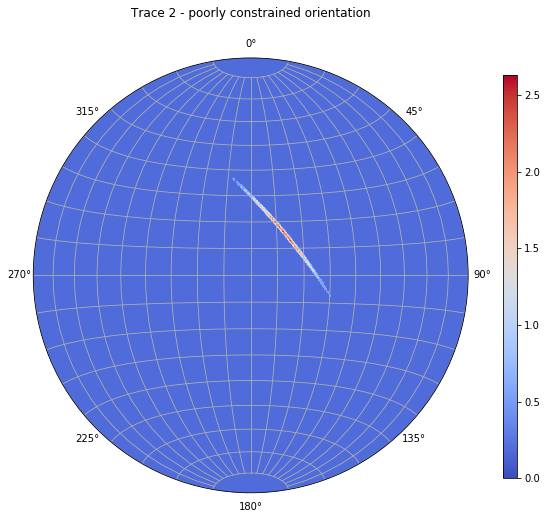

In [40]:
##TRACE 2 - Poorly defined orientation
x = [695.818970,695.818970,695.900024,695.965027,696.013977,696.081970,696.164001,696.254028,696.302002,696.354004,696.427979,696.517029,696.594971,696.664001,696.711975,696.809998,696.895996,696.895996,696.895996,696.960999,697.059021,697.129028,697.189026,697.275024,697.330994,697.388000,697.465027,697.546021,697.619995,697.671997,697.762024,697.838989,697.862976,697.932007,697.963013,697.994995,698.044006,698.125000,698.185974,698.250000,698.327026,698.327026,698.327026,698.372009,698.456970,698.505981,698.573975,698.648010,698.708984,698.794006,698.883972,698.978027,699.043030,699.137024,699.210022,699.299988,699.390015,699.463013,699.479004,699.523010,699.591003,699.664001,699.721008,699.770020,699.848022,699.942017,700.002014,700.002014,700.002014,700.054993,700.148987,700.218018,700.267029,700.351990,700.416992,700.489990,700.559998,700.632996,700.734985,700.812988,700.911011,700.992981,701.036987,701.072021,701.120972]
y = [836.835022,836.835022,836.896973,836.971008,837.036987,837.103027,837.164978,837.210999,837.276001,837.333984,837.392029,837.437988,837.489014,837.554016,837.619995,837.648987,837.661987,837.661987,837.661987,837.715027,837.744995,837.789978,837.851990,837.906006,837.976013,838.044983,838.094971,838.135986,838.192993,838.250000,838.296021,838.346008,838.419006,838.486023,838.562988,838.640991,838.706970,838.770020,838.853027,838.927002,838.997986,838.997986,838.997986,839.051025,839.104980,839.169983,839.236023,839.293030,839.335022,839.388977,839.434998,839.471985,839.505005,839.544006,839.601990,839.648010,839.693970,839.752014,839.799988,839.872986,839.939026,839.995972,840.065979,840.091003,840.119995,840.158997,840.221008,840.221008,840.221008,840.276978,840.315979,840.361023,840.406982,840.460999,840.513977,840.570984,840.617004,840.653992,840.676025,840.703979,840.734009,840.796997,840.892029,840.982971,841.049011]
z = [517.781982,517.781982,517.791992,517.830994,517.869019,517.898010,517.927979,517.947021,518.004028,518.033020,518.052979,518.044983,518.054993,518.103027,518.159973,518.179016,518.197998,518.197998,518.197998,518.255005,518.265015,518.302979,518.349976,518.369995,518.427002,518.484009,518.513000,518.568970,518.616028,518.682007,518.702026,518.711975,518.768982,518.789001,518.828003,518.875000,518.895020,518.869019,518.890015,518.909973,518.929993,518.929993,518.929993,518.968018,518.997009,519.062988,519.109985,519.148987,519.177002,519.197021,519.226013,519.245972,519.283020,519.257019,519.304016,519.323975,519.315979,519.362976,519.447021,519.504028,519.552002,519.598999,519.656006,519.674988,519.666992,519.650024,519.697021,519.697021,519.697021,519.763000,519.763977,519.793030,519.812012,519.831970,519.888000,519.935974,519.965027,520.002991,520.021973,520.068970,520.096985,520.080017,520.072998,520.075012,520.104980]

normal = np.array([0.47,-0.76,0.45])
normal = normal / np.linalg.norm(normal)

#calculate normal-estimate tensor
cov = np.cov(np.vstack([x,y,z]))

#generate and plot estimate
grid = pdf.grid(500)
out = pdf.posteriorExp1D(grid,cov,10,normal,steps=100) #len(x)
stereonet = plotGrids(["Trace 2 - poorly constrained orientation"],grid,[out]) #plot results

Structure Normal Estimation
-----------

The following example implements a moving-window search algorithm to identify the most planar subsections of a trace, allowing the estimation of normal vectors at each point along structures comprised of multiple differently oriented segments.

In [41]:
minSize=100
n = 10 #degrees of freedom

#poor plane
#x = [695.818970,695.818970,695.900024,695.965027,696.013977,696.081970,696.164001,696.254028,696.302002,696.354004,696.427979,696.517029,696.594971,696.664001,696.711975,696.809998,696.895996,696.895996,696.895996,696.960999,697.059021,697.129028,697.189026,697.275024,697.330994,697.388000,697.465027,697.546021,697.619995,697.671997,697.762024,697.838989,697.862976,697.932007,697.963013,697.994995,698.044006,698.125000,698.185974,698.250000,698.327026,698.327026,698.327026,698.372009,698.456970,698.505981,698.573975,698.648010,698.708984,698.794006,698.883972,698.978027,699.043030,699.137024,699.210022,699.299988,699.390015,699.463013,699.479004,699.523010,699.591003,699.664001,699.721008,699.770020,699.848022,699.942017,700.002014,700.002014,700.002014,700.054993,700.148987,700.218018,700.267029,700.351990,700.416992,700.489990,700.559998,700.632996,700.734985,700.812988,700.911011,700.992981,701.036987,701.072021,701.120972]
#y = [836.835022,836.835022,836.896973,836.971008,837.036987,837.103027,837.164978,837.210999,837.276001,837.333984,837.392029,837.437988,837.489014,837.554016,837.619995,837.648987,837.661987,837.661987,837.661987,837.715027,837.744995,837.789978,837.851990,837.906006,837.976013,838.044983,838.094971,838.135986,838.192993,838.250000,838.296021,838.346008,838.419006,838.486023,838.562988,838.640991,838.706970,838.770020,838.853027,838.927002,838.997986,838.997986,838.997986,839.051025,839.104980,839.169983,839.236023,839.293030,839.335022,839.388977,839.434998,839.471985,839.505005,839.544006,839.601990,839.648010,839.693970,839.752014,839.799988,839.872986,839.939026,839.995972,840.065979,840.091003,840.119995,840.158997,840.221008,840.221008,840.221008,840.276978,840.315979,840.361023,840.406982,840.460999,840.513977,840.570984,840.617004,840.653992,840.676025,840.703979,840.734009,840.796997,840.892029,840.982971,841.049011]
#z = [517.781982,517.781982,517.791992,517.830994,517.869019,517.898010,517.927979,517.947021,518.004028,518.033020,518.052979,518.044983,518.054993,518.103027,518.159973,518.179016,518.197998,518.197998,518.197998,518.255005,518.265015,518.302979,518.349976,518.369995,518.427002,518.484009,518.513000,518.568970,518.616028,518.682007,518.702026,518.711975,518.768982,518.789001,518.828003,518.875000,518.895020,518.869019,518.890015,518.909973,518.929993,518.929993,518.929993,518.968018,518.997009,519.062988,519.109985,519.148987,519.177002,519.197021,519.226013,519.245972,519.283020,519.257019,519.304016,519.323975,519.315979,519.362976,519.447021,519.504028,519.552002,519.598999,519.656006,519.674988,519.666992,519.650024,519.697021,519.697021,519.697021,519.763000,519.763977,519.793030,519.812012,519.831970,519.888000,519.935974,519.965027,520.002991,520.021973,520.068970,520.096985,520.080017,520.072998,520.075012,520.104980]
#normal = np.array([0.47,-0.76,0.45]) #outcrop normal

#good plane
x = [660.255005,660.255005,660.262024,660.348999,660.431030,660.487976,660.554016,660.632019,660.700989,660.754028,660.844971,660.909973,661.008972,661.106995,661.197021,661.244995,661.348022,661.424988,661.523987,661.614014,661.700012,661.789978,661.893005,661.893005,661.893005,661.971008,662.070007,662.168030,662.270996,662.353027,662.439026,662.528992,662.614990,662.671997,662.762024,662.859985,662.924988,662.994995,663.093018,663.182983,663.268005,663.336975,663.427002,663.520996,663.585999,663.651001,663.708008,663.784973,663.854004,663.953003,664.046997,664.120972,664.219971,664.310974,664.409973,664.508972,664.590027,664.638977,664.729004,664.729004,664.729004,664.822998,664.875977,664.929016,665.026978,665.083984,665.179016,665.276978,665.370972,665.465027,665.567993,665.666016,665.765015,665.854980,665.932983,666.007019,666.088989,666.174988,666.260986,666.351013,666.421021,666.510986,666.580017,666.666016,666.752014,666.825012,666.903015,666.976990,667.054993,667.153015,667.239014,667.312012,667.369019,667.442017,667.536011,667.638977,667.711975,667.815002,667.896973,667.958008,668.052002,668.130005,668.130005,668.130005,668.169983,668.231018,668.309021,668.382019,668.465027,668.546997,668.632996,668.731995,668.830017,668.921021,669.020020,669.104980,669.195984,669.260986,669.351013,669.432007,669.526001,669.616028,669.705994,669.804016,669.906982,669.987976,670.070007,670.169006,670.263000,670.366028,670.455994,670.455994,670.455994,670.526001,670.620972,670.715027,670.783997,670.874023,670.973022,671.046021,671.145020,671.210022,671.270996,671.361023,671.429993,671.525024,671.611023,671.684021,671.757996,671.851990,671.950012,672.012024,672.101990,672.171021,672.270020,672.343018,672.445984,672.536011,672.630005,672.729004,672.810974,672.905029,672.994995,673.085022,673.174988,673.276978,673.380005,673.469971,673.469971,673.469971,673.513977,673.546021,673.565979,673.614014,673.695007,673.747009,673.794983,673.848022,673.921021,674.002014,674.067017,674.148010,674.234009,674.289978,674.346985,674.416016,674.473022,674.559021,674.632996,674.705994,674.705994,674.705994,674.776001,674.840027,674.918030,674.994995,675.075989,675.161987,675.205994,675.291016,675.364014,675.453979,675.536011,675.625000,675.728027,675.783997,675.848999,675.931030,675.982971,676.044006,676.117004,676.182007,676.189026,676.257996,676.302002,676.357971,676.398010,676.463013,676.549011,676.549011,676.549011,676.643005,676.708008,676.773010,676.870972,676.935974,677.030029,677.106995,677.151001,677.232971,677.309998,677.390991,677.460022,677.525024,677.581970,677.630005,677.716003,677.776001,677.848999,677.927002,677.982971,678.036011,678.104980,678.174011,678.237976,678.307007,678.380005,678.469971,678.526978,678.599976,678.698975,678.783997,678.812988,678.812988,678.812988,678.911011,678.997009,679.065979,679.130005,679.198975,679.239014,679.270996,679.322998,679.383972,679.448975,679.530029,679.604004,679.681030,679.745972,679.822998,679.895996,679.981995,680.062988,680.153015,680.221985,680.270020,680.302002,680.349976,680.403015,680.455017,680.499023,680.534973,680.598999,680.598999,680.598999,680.668030,680.716980,680.776978,680.830017,680.882019,680.942993,681.010986,681.096985,681.179016,681.268005,681.328979,681.414978,681.484009,681.570007,681.651978,681.754028,681.848022,681.913025,681.978027,682.039978,682.125000,682.210999,682.296021,682.390015,682.476013,682.557983,682.648010,682.737976,682.823975,682.823975,682.823975,682.918030,682.974976,683.060974,683.143005,683.208008,683.281006,683.359009,683.440002,683.521973,683.604004,683.669006,683.767029,683.810974,683.893005,683.979004,684.072998,684.145996,684.239990,684.314026,684.387024,684.435974,684.500977,684.573975,684.638977,684.638977,684.638977,684.708008,684.789001,684.879028,684.978027,685.039001,685.119995,685.193970,685.278992,685.335999,685.434021,685.479004,685.577026,685.645996,685.728027,685.825989,685.919983,686.018005,686.088013,686.182007,686.263000,686.348999,686.398010,686.398010,686.398010,686.447021,686.531982,686.617981,686.700012,686.784973,686.859009,686.943970,687.033997,687.116028,687.197021,687.262024,687.318970,687.372009,687.440979,687.440979,687.440979,687.518005,687.549988,687.598022,687.638000,687.697998,687.758972,687.799011,687.883972,687.948975,688.026001,688.036987,688.059998,688.112976,688.112976,688.112976,688.107971,688.143005,688.187012,688.236023,688.276001,688.312012,688.380005,688.469971,688.543030,688.637024,688.718994,688.804993,688.804993,688.804993,688.882019,688.947021,689.015991,689.064026,689.137024,689.213989,689.291992,689.340027,689.393005,689.453003,689.534973,689.534973,689.534973,689.575012,689.664978,689.721008,689.721008,689.721008,689.760986]    
y = [814.494019,814.494019,814.559021,814.531006,814.489014,814.476013,814.487976,814.474976,814.500000,814.494019,814.479004,814.489990,814.479004,814.507996,814.533020,814.578003,814.599976,814.648987,814.679016,814.684021,814.695984,814.679993,814.661011,814.661011,814.661011,814.669006,814.656982,814.666016,814.666016,814.666016,814.679016,814.682983,814.674988,814.703003,814.728027,814.737000,814.768982,814.793030,814.822998,814.869019,814.922974,814.968018,815.013977,815.052002,815.104980,815.158020,815.206970,815.257019,815.281006,815.289978,815.286011,815.281006,815.250000,815.234985,815.203003,815.192017,815.211975,815.255981,815.281006,815.281006,815.281006,815.297974,815.314026,815.330017,815.338013,815.366028,815.362976,815.392029,815.409973,815.427002,815.447998,815.456970,815.445984,815.450989,815.437988,815.432983,815.434021,815.445984,815.458984,815.463989,815.489014,815.513000,815.536987,815.549988,815.562012,815.578003,815.585999,815.601990,815.612000,815.620972,815.655029,815.690979,815.739990,815.776978,815.814026,815.835999,815.853027,815.854004,815.874023,815.893982,815.911011,815.940002,815.940002,815.940002,815.979004,815.999023,816.007019,816.002991,815.981995,815.981995,815.953003,815.942017,815.950012,815.955017,815.922974,815.956970,815.961975,815.994995,816.039978,816.080994,816.119995,816.166016,816.213013,816.242981,816.244995,816.307007,816.348999,816.359009,816.375977,816.377014,816.362000,816.362000,816.362000,816.385986,816.362976,816.380981,816.405029,816.408997,816.418030,816.434021,816.442993,816.476013,816.517029,816.541992,816.565979,816.562012,816.573975,816.591003,816.606995,816.622986,816.612000,816.630981,816.635986,816.659973,816.648987,816.664978,816.664978,816.669983,816.687012,816.695984,816.695984,816.713013,816.737976,816.783997,816.809998,816.830994,816.853027,816.836975,816.836975,816.836975,816.911011,816.987976,817.070007,817.135010,817.197021,817.275024,817.361023,817.439026,817.497009,817.559021,817.632996,817.695007,817.749023,817.818970,817.888977,817.934021,817.960999,817.932983,817.948975,817.966980,817.966980,817.966980,818.012024,818.085999,818.156982,818.228027,818.289978,818.344971,818.418030,818.471985,818.530029,818.575989,818.638977,818.684998,818.706970,818.776978,818.851013,818.914001,818.992004,819.052979,819.112000,819.187012,819.250977,819.317993,819.390991,819.460999,819.541992,819.594971,819.629028,819.629028,819.629028,819.666992,819.741028,819.794983,819.825012,819.877991,819.916016,819.965027,820.039001,820.101990,820.171997,820.234009,820.301025,820.375977,820.447998,820.533997,820.588989,820.671997,820.729004,820.778992,820.848999,820.906006,820.950989,821.018005,821.093018,821.158997,821.216003,821.262024,821.310974,821.348999,821.379028,821.411987,821.434998,821.434998,821.434998,821.466003,821.520020,821.565002,821.617981,821.684021,821.765015,821.843018,821.921021,821.984009,822.057983,822.120972,822.179016,822.229004,822.304016,822.375000,822.432983,822.487000,822.528992,822.575012,822.640991,822.728027,822.783997,822.870972,822.948975,823.026978,823.122009,823.213013,823.286987,823.286987,823.286987,823.354004,823.398010,823.481018,823.559021,823.637024,823.719971,823.786011,823.840027,823.880981,823.927979,823.968018,824.023010,824.088989,824.122009,824.122009,824.143005,824.181030,824.192993,824.224976,824.245972,824.299988,824.354004,824.387024,824.424011,824.458984,824.500000,824.546021,824.572021,824.585022,824.585022,824.585022,824.601013,824.609009,824.620972,824.620972,824.655029,824.711975,824.762024,824.802979,824.843994,824.864990,824.896973,824.926025,824.958008,825.000000,825.033020,825.049988,825.067017,825.104980,825.142029,825.179016,825.223022,825.276978,825.333984,825.367004,825.367004,825.367004,825.411987,825.453003,825.478027,825.487000,825.507019,825.547974,825.606018,825.661011,825.708984,825.739990,825.771973,825.801025,825.825012,825.846008,825.875977,825.913025,825.942993,825.987976,826.026978,826.070007,826.125000,826.148010,826.148010,826.148010,826.171997,826.226990,826.281982,826.323975,826.356995,826.393982,826.447998,826.494995,826.536011,826.577026,826.630005,826.679016,826.716003,826.760986,826.760986,826.760986,826.831970,826.909973,826.995972,827.077026,827.159973,827.242004,827.302979,827.356995,827.431030,827.502014,827.578979,827.672974,827.752991,827.752991,827.752991,827.841980,827.932983,828.028992,828.114990,828.197998,828.267029,828.333008,828.377991,828.414978,828.453003,828.474976,828.508972,828.508972,828.508972,828.578979,828.653015,828.718994,828.783997,828.841980,828.913025,828.984009,829.049011,829.106018,829.168030,829.229980,829.229980,829.229980,829.291992,829.338013,829.408020,829.408020,829.408020,829.468994]
z = [496.069000,496.069000,496.106995,496.153015,496.207001,496.281006,496.364014,496.410004,496.475006,496.566986,496.595001,496.669006,496.678009,496.707001,496.743988,496.809998,496.820007,496.876007,496.868011,496.895996,496.951996,496.979004,496.979004,496.979004,496.979004,497.044006,497.080994,497.118011,497.145996,497.201996,497.257996,497.312988,497.359009,497.424011,497.462006,497.498993,497.574005,497.621002,497.640015,497.660004,497.688995,497.735992,497.755005,497.765991,497.812988,497.878998,497.925995,497.963989,498.037994,498.075989,498.104004,498.177002,498.186005,498.167999,498.186005,498.167999,498.233002,498.316986,498.363007,498.363007,498.363007,498.410004,498.466003,498.540009,498.576996,498.661011,498.670013,498.699005,498.717987,498.746002,498.765015,498.794006,498.785004,498.830994,498.885986,498.959991,499.006012,499.062012,499.098999,499.100006,499.136993,499.183990,499.257996,499.313995,499.351013,499.425995,499.489990,499.554993,499.536987,499.566010,499.557007,499.622986,499.697998,499.753998,499.782990,499.792999,499.821014,499.829987,499.894989,499.959991,499.997986,500.062988,500.062988,500.062988,500.147003,500.221008,500.277008,500.341003,500.404999,500.470001,500.506989,500.533997,500.571991,500.600006,500.618011,500.618988,500.627991,500.694000,500.722992,500.778992,500.779999,500.772003,500.755005,500.756012,500.738007,500.766998,500.778015,500.751007,500.769989,500.778992,500.769989,500.769989,500.769989,500.825989,500.799011,500.817993,500.891998,500.937988,500.967010,501.031006,501.049988,501.079010,501.144012,501.182007,501.256012,501.303009,501.348999,501.404999,501.470001,501.515991,501.553009,501.627991,501.674011,501.730011,501.757996,501.822998,501.851013,501.878998,501.924988,501.953003,501.963013,502.000000,502.037994,502.066986,502.076996,502.096008,502.114990,502.143005,502.143005,502.143005,502.191010,502.256989,502.277008,502.324005,502.354004,502.401001,502.440002,502.488007,502.526001,502.554993,502.593994,502.614014,502.643005,502.671997,502.729004,502.794006,502.868988,502.914001,502.960999,502.962006,502.962006,502.962006,502.980988,503.019989,503.031006,503.050995,503.052002,503.053986,503.110992,503.131012,503.169006,503.178986,503.199005,503.200989,503.183014,503.230988,503.269012,503.270996,503.309998,503.347992,503.348999,503.351013,503.425995,503.417999,503.475006,503.532013,503.588989,503.645996,503.674011,503.674011,503.674011,503.657013,503.695007,503.705994,503.716003,503.773010,503.800995,503.848999,503.895996,503.898010,503.917999,503.946991,503.958008,503.941986,503.888000,503.890015,503.872986,503.903015,503.950012,503.970001,504.016998,504.065002,504.102997,504.122986,504.125000,504.153992,504.200989,504.212006,504.277008,504.296997,504.298004,504.335999,504.419006,504.419006,504.419006,504.402008,504.411987,504.477997,504.533997,504.572998,504.619995,504.649994,504.687988,504.690002,504.700989,504.721008,504.721985,504.751007,504.734985,504.755005,504.765015,504.776001,504.786011,504.806000,504.825989,504.837006,504.920990,504.959991,504.980011,505.019012,505.011993,505.040985,505.052002,505.052002,505.052002,505.053986,505.118988,505.148987,505.178009,505.226013,505.237000,505.266998,505.268005,505.315002,505.316010,505.372986,505.391998,505.421997,505.468994,505.523987,505.533997,505.535004,505.600006,505.674988,505.730011,505.750000,505.778992,505.834991,505.855011,505.838013,505.885010,505.877014,505.915009,505.924011,505.924011,505.924011,505.971008,506.053986,506.101013,506.165009,506.165985,506.213989,506.252014,506.308014,506.346008,506.402008,506.476013,506.505005,506.579010,506.598999,506.618011,506.656006,506.701996,506.721985,506.740997,506.796997,506.872009,506.919006,506.967010,506.994995,506.994995,506.994995,507.061005,507.108002,507.145996,507.183014,507.265991,507.286011,507.333008,507.325989,507.399994,507.382996,507.447998,507.476990,507.550995,507.597992,507.608002,507.636993,507.627991,507.684998,507.677002,507.640991,507.623993,507.699005,507.699005,507.699005,507.753998,507.773987,507.756989,507.768005,507.804993,507.842987,507.845001,507.855011,507.902008,507.931000,507.997009,508.062012,508.109009,508.165985,508.165985,508.165985,508.166992,508.187988,508.226013,508.282990,508.312988,508.342010,508.416992,508.428009,508.466003,508.467987,508.533997,508.563995,508.537994,508.537994,508.537994,508.585999,508.569000,508.562012,508.563995,508.593994,508.651001,508.688995,508.717987,508.773987,508.803009,508.785004,508.795013,508.795013,508.795013,508.816010,508.854004,508.882996,508.949005,508.987000,509.007996,508.990997,509.037994,509.095001,509.123993,509.144012,509.144012,509.144012,509.173004,509.183990,509.230988,509.230988,509.230988,509.296997]
normal = np.array([0.197,-0.927,0.319]) #outcrop normal

#ensure normal vector is actually normal...
normal = normal / np.linalg.norm(normal)

#print
bearing,plunge = np.rad2deg(pdf.vec2TrendPlunge(normal))
print("Outcrop normal is %d->%d" % (plunge,bearing))


#build data structures to store best-fit planes in
mlik_matrix = np.zeros([len(x),len(x)]) #maximum likelihood probability (higher values=tighter posterior=better constrained plane)
bearing_matrix = np.zeros([len(x),len(x)]) #trend of maximum-likelihood estimate
plunge_matrix = np.zeros([len(x),len(x)]) #plunge of maximum-likelihood estimate

for xmin in range(0,len(x)):
    for xmax in range(xmin,len(x)):
        if xmax-xmin < minSize:
            continue #minimum sampling distance
        
        #calculate covariance matrix of this data slice
        cov = np.cov(np.vstack([x[xmin:xmax],y[xmin:xmax],z[xmin:xmax]]))
        
        #calculate and sort egenvectors
        eval,evec = np.linalg.eig(cov)
        idx = eval.argsort()[::-1] #sort eigens in decending order...
        eval = eval[idx]
        evec = evec[:,idx] #n.b. columns of evec are vectors....

        #calculate and store maximum likelihood
        phi,theta = pdf.vec2TrendPlunge(evec[:,2])
        alpha = np.arcsin(evec[2,1] / np.cos(theta)) #alpha = arcsin(eigVector2.z / cos(theta))
        
        #store trend and plunge for future reference
        bearing_matrix[xmin,xmax] = np.rad2deg(phi)
        plunge_matrix[xmin,xmax] = np.rad2deg(theta)
        
        #calculate and store posterior density of the maximum likelihood location. In almost all cases
        #this represents the maxima of the posterior distribution (except when the prior gets heavily involved)
        lsf = pdf.wishLSF(cov*n,n)
        mlik_matrix[xmin,xmax] = np.exp(pdf.logWish(cov*n,n,phi,theta,alpha,eval[0],eval[1],eval[2],lsf)) #likelihood 
        mlik_matrix[xmin,xmax] *= pdf.pp(phi,theta,normal[0],normal[1],normal[2]) #log prior
            
            

Outcrop normal is 18->348


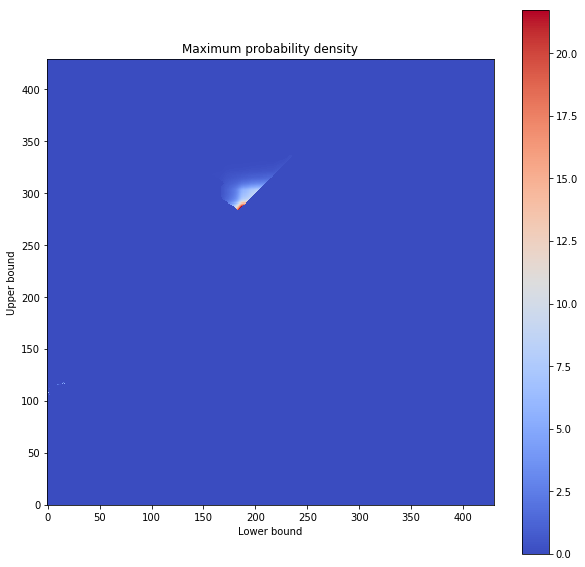

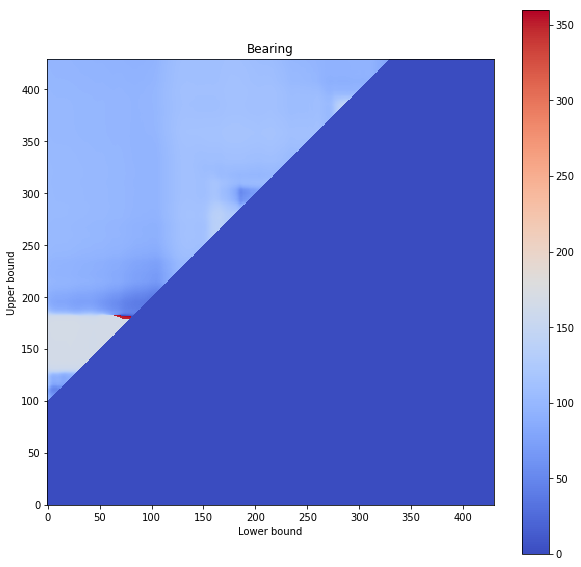

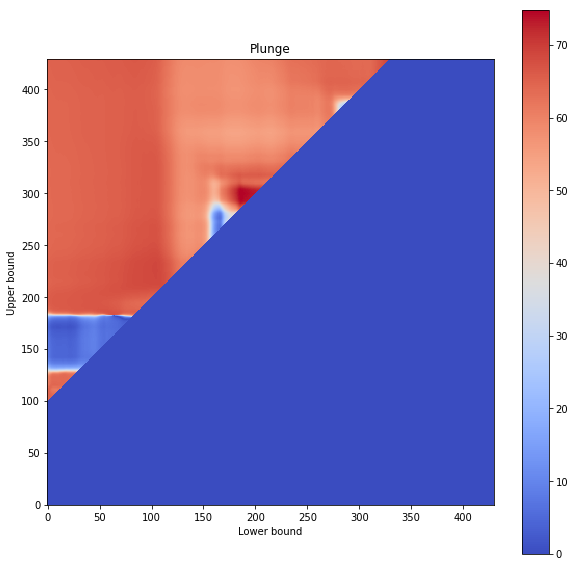

In [42]:
#plot matrices
fig = plt.figure(figsize=(10,10))
plt.imshow(mlik_matrix.T,origin='lower',cmap="coolwarm")
plt.title("Maximum probability density")
plt.xlabel("Lower bound")
plt.ylabel("Upper bound")
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(10,10))
plt.imshow(bearing_matrix.T,origin='lower',cmap='coolwarm')
plt.title("Bearing")
plt.xlabel("Lower bound")
plt.ylabel("Upper bound")
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(10,10))
plt.imshow(plunge_matrix.T,origin='lower',cmap='coolwarm')
plt.title("Plunge")
plt.xlabel("Lower bound")
plt.ylabel("Upper bound")
plt.colorbar()
plt.show()

In [43]:
#identify unique segmens 
segments = {} #segments dict containing segments as keys and lists of points as values

#loop through points in trace
for n in range(len(x)):
    
    #get domain containing all possible combinations of start,end that include point n
    domain = mlik_matrix[0:n+1,n:len(x)]
    idx = np.argmax(domain.ravel())
    start,end = np.unravel_index(idx,domain.shape) #get index of segment with maximum a-postiori    
    
    #map start,end from domain indices to matrix indices
    end += n
    
    #store segment
    if (start,end) in segments:
        segments[(start,end)].append(n) #add this point to the corresponding segment
    else:
        segments[(start,end)] = [n] #create new segment

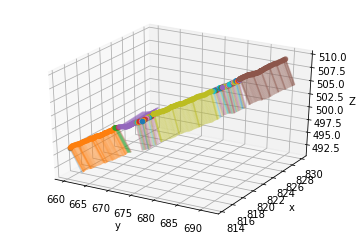

In [44]:
#plot
#%matplotlib qt ##uncomment this line to allow 3D interactive plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#plot points
for key in segments:
    points = segments[key]
    paths = ax.scatter(np.array(x)[points], np.array(y)[points], np.array(z)[points])

    #get normal vector
    phi = np.deg2rad(bearing_matrix[key[0],key[1]])
    theta = np.deg2rad(plunge_matrix[key[0],key[1]])
    norm = pdf.trendPlunge2Vec(phi,theta)
    
    #plot lines for vectors
    for p in points:
        ax.plot([x[p],x[p]+norm[0]*5],[y[p],y[p]+norm[1]*5],[z[p],z[p]+norm[2]*5],alpha=0.25,c=paths.get_facecolor()[0])
    
ax.set_xlabel('y')
ax.set_ylabel('x')
ax.set_zlabel('Z')

plt.show()